# Predicting the stock market 10 days in the future

# Clark Whitehead

# ECON 427 Final Project

# May 3 2022

In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tqdm

import numpy as np

import pandas as pd

import yfinance as yf

[*********************100%***********************]  1 of 1 completed


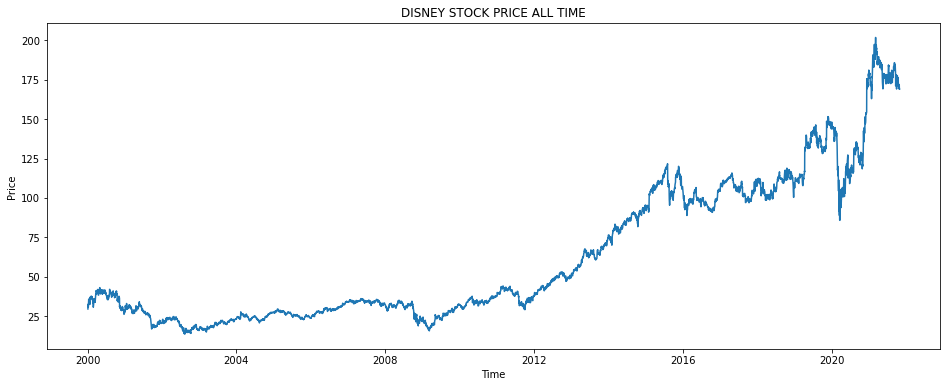

In [2]:
msft = yf.Ticker("DIS")


hist = msft.history(period="max")

#using CLOSE price only
data = yf.download("DIS", start="2000-01-01", end="2021-11-01")['Close']

plt.figure(figsize=(16, 6))
plt.plot(data)
plt.title('DISNEY STOCK PRICE ALL TIME')
plt.ylabel('Price')
plt.xlabel('Time')
plt.show();

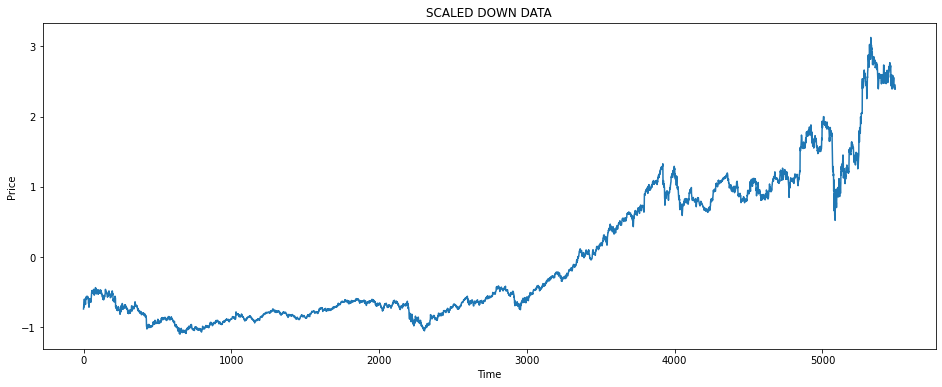

In [3]:
X = data.to_numpy().reshape(-1,1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train = torch.from_numpy(X_scaled).float()

plt.figure(figsize=(16, 6))
plt.plot(X_scaled)
plt.title('SCALED DOWN DATA')
plt.ylabel('Price')
plt.xlabel('Time')
plt.show();

In [4]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.i2h = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.i2o = nn.Linear(input_dim + hidden_dim, output_dim)
        
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), dim=1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, hidden_dim)
    
hidden_dim = 128
    
rnn = RNN(1, 128, 1)
optimizer = torch.optim.SGD(rnn.parameters(), lr=.001)
loss_fn = nn.MSELoss()

In [5]:
def train(input_tensor, y_tensor):
    
    hidden = rnn.init_hidden()
    
    for i in range(input_tensor.shape[0]):
        output, hidden = rnn(input_tensor[i].view(1,1), hidden)
        
    loss = loss_fn(output, y_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

In [6]:
loss_list1 = np.zeros(X_train.shape[0]-100)

for i in tqdm.trange(X_train.shape[0]-100):
    
    input_tensor = X_train[i:i+60]
    y = X_train[i+70].view(1,1)
    
    output, loss = train(input_tensor, y)

    loss_list1[i] = loss
        
        
print("output = {}".format(output))
print("loss = {}".format(loss))

100%|██████████| 5393/5393 [00:28<00:00, 188.94it/s]

output = tensor([[2.7559]], grad_fn=<AddmmBackward>)
loss = 0.0019155899062752724


# Loss after 5,000 trainings

Text(0.5, 0, 'Iters')

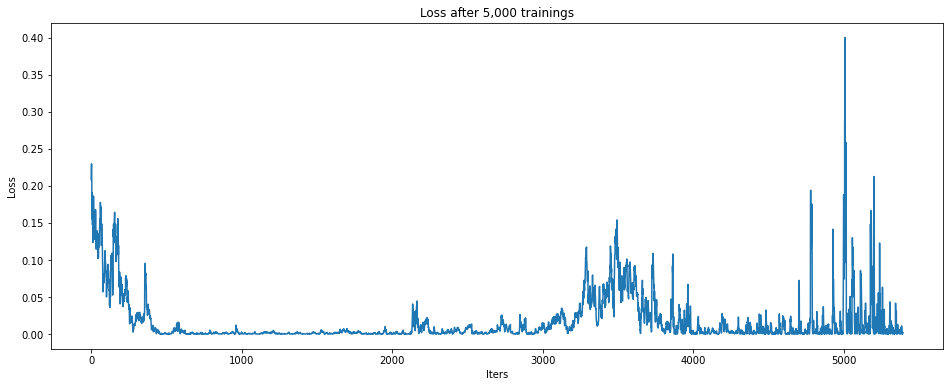

In [7]:
plt.figure(figsize=(16,6))
plt.plot(loss_list1)
plt.title('Loss after 5,000 trainings')
plt.ylabel('Loss')
plt.xlabel('Iters')

In [8]:
def running_mean(x, N):
    #x == an array of data. N == number of samples per average
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)
  
val = [-30.45, -2.65, 56.61, 47.13, 47.95, 30.45, 2.65, -28.31, -47.13, -95.89]
print(running_mean(val, 3))

[  7.83666667  33.69666667  50.56333333  41.84333333  27.01666667
   1.59666667 -24.26333333 -57.11      ]


Text(0.5, 0, 'Iters')

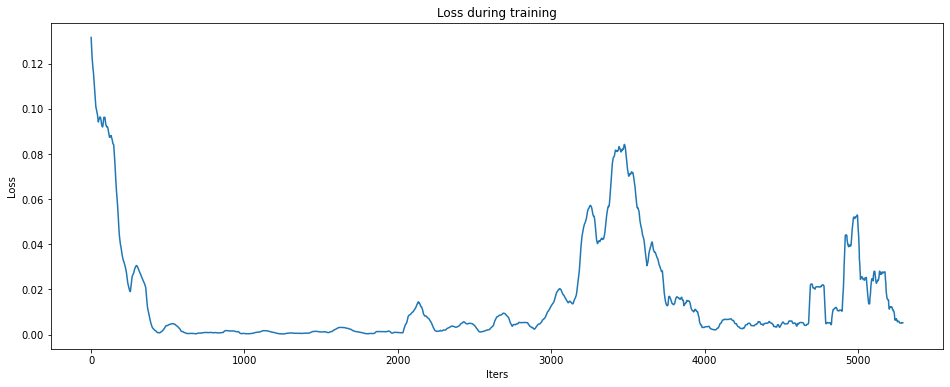

In [10]:
plt.figure(figsize=(16,6))
plt.plot(running_mean(loss_list1, 100))
plt.title('Loss during training')
plt.ylabel('Loss')
plt.xlabel('Iters')

# Loss after 10,000 trainings

In [11]:
loss_list2 = np.zeros(X_train.shape[0]-100)

for i in tqdm.trange(X_train.shape[0]-100):
    
    input_tensor = X_train[i:i+60]
    y = X_train[i+70].view(1,1)
    
    output, loss = train(input_tensor, y)

    loss_list2[i] = loss
        
        
print("output = {}".format(output))
print("loss = {}".format(loss))

100%|██████████| 5393/5393 [00:28<00:00, 187.79it/s]

output = tensor([[2.7685]], grad_fn=<AddmmBackward>)
loss = 0.0031845716293901205


Text(0.5, 0, 'Iters')

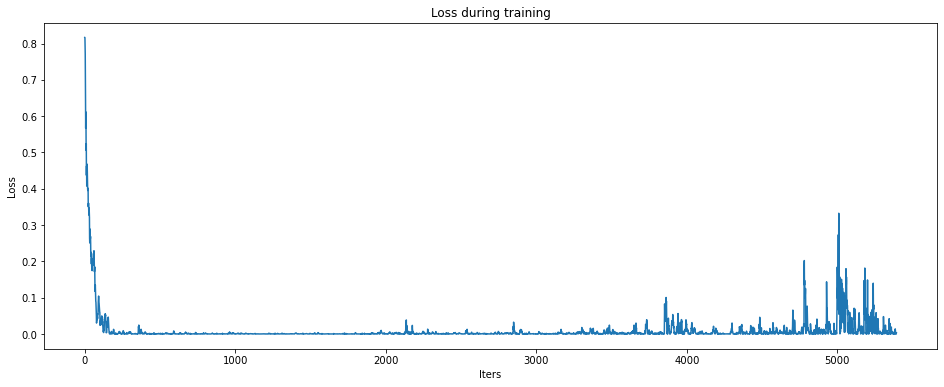

In [12]:
plt.figure(figsize=(16,6))
plt.plot(loss_list2)
plt.title('Loss during training')
plt.ylabel('Loss')
plt.xlabel('Iters')

Text(0.5, 0, 'Iters')

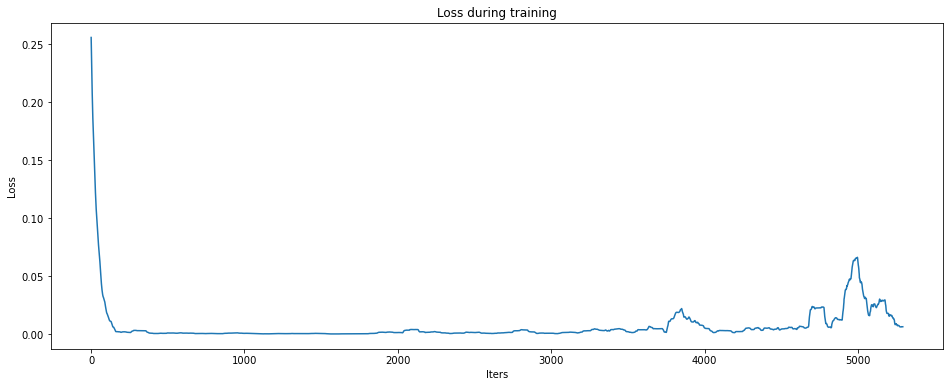

In [13]:
plt.figure(figsize=(16,6))
plt.plot(running_mean(loss_list2, 100))
plt.title('Loss during training')
plt.ylabel('Loss')
plt.xlabel('Iters')

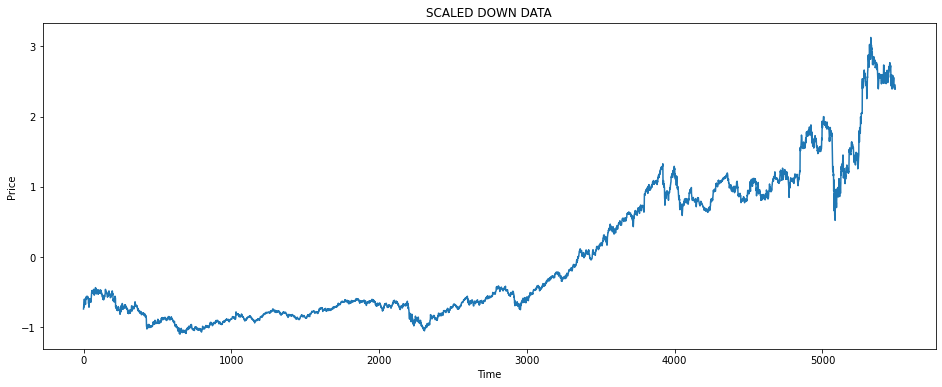

In [78]:
plt.figure(figsize=(16, 6))
plt.plot(X_scaled)
plt.title('SCALED DOWN DATA')
plt.ylabel('Price')
plt.xlabel('Time')
plt.show();

In [14]:
def predict(input_tensor):
    
    with torch.no_grad():
    
        hidden = rnn.init_hidden()

        for i in range(input_tensor.shape[0]):
            output, hidden = rnn(input_tensor[i].view(1,1), hidden)
    
    return output

In [15]:
predict(X_train[4440:4500])

tensor([[1.0718]])

In [16]:
X_train[4501]

tensor([0.9091])

In [17]:
list1 = np.zeros(X_train.shape[0]-100)

for i in tqdm.trange(X_train.shape[0]-100):
    list1[i] = predict(X_train[i:i+60])

100%|██████████| 5393/5393 [00:13<00:00, 406.82it/s]


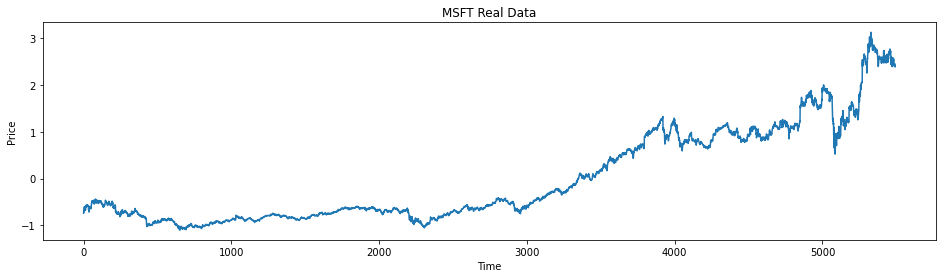

In [18]:
plt.figure(figsize=(16,4))
plt.plot(X_train)
plt.title('MSFT Real Data')
plt.ylabel('Price')
plt.xlabel('Time')
plt.show();

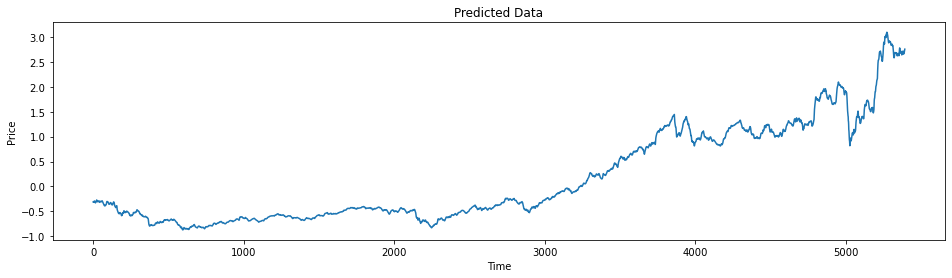

In [19]:
plt.figure(figsize=(16, 4))
plt.plot(list1)
plt.title('Predicted Data')
plt.ylabel('Price')
plt.xlabel('Time')
plt.show();

# Apple

[*********************100%***********************]  1 of 1 completed


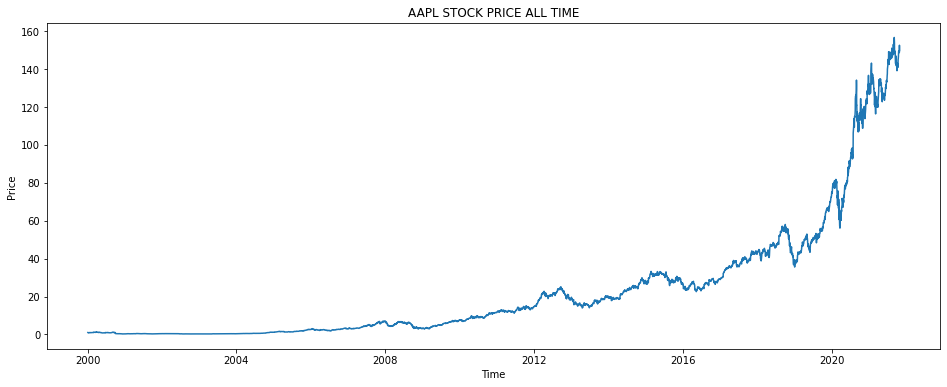

In [20]:
#using CLOSE price only
data = yf.download("AAPL", start="2000-01-01", end="2021-11-01")['Close']

plt.figure(figsize=(16, 6))
plt.plot(data)
plt.title('AAPL STOCK PRICE ALL TIME')
plt.ylabel('Price')
plt.xlabel('Time')
plt.show();

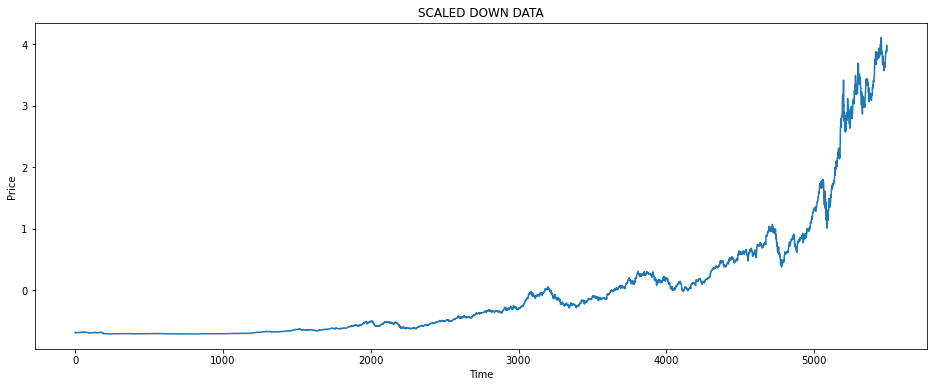

In [23]:
X = data.to_numpy().reshape(-1,1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train = torch.from_numpy(X_scaled).float()

X_scaled
plt.figure(figsize=(16, 6))
plt.plot(X_scaled)
plt.title('SCALED DOWN DATA')
plt.ylabel('Price')
plt.xlabel('Time')
plt.show();

In [24]:
predict(X_train[2940:3000])

tensor([[-0.1074]])

In [25]:
X_train[3001]

tensor([-0.2844])

In [26]:
list2 = np.zeros(1000)

for i in range(1000):
    list2[i] = predict(X_train[3000+i:3000+i+60])

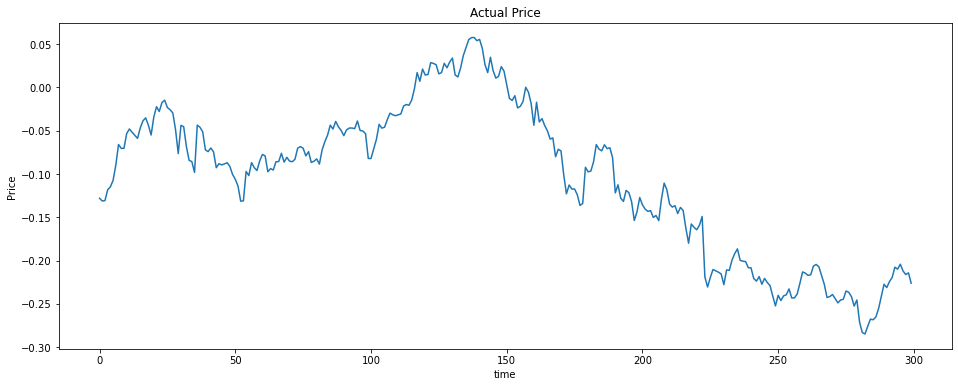

In [27]:
plt.figure(figsize=(16,6))
plt.plot(X_train[3061:3361])
plt.title("Actual Price")
plt.ylabel("Price")
plt.xlabel("time")
plt.show()

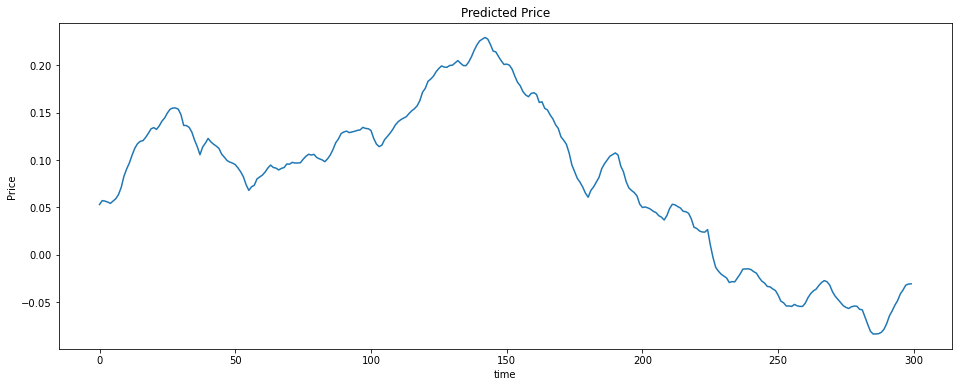

In [28]:
plt.figure(figsize=(16,6))
plt.plot(list2[:300])
plt.title("Predicted Price")
plt.ylabel("Price")
plt.xlabel("time")
plt.show()